# 1. Building Container Images for High-Performance Computing
---

This workshop covers building container images with [Docker](https://www.docker.com) and [Singularity](https://www.sylabs.io/singularity).

Among the topics covered are container specification files, the basics of building container images, and techniques for managing the size of container images.

The lab assumes you are familiar with basic Linux shell commands.

Before beginning, please make sure the lab environment is correctly setup by running the two cells below.  To run a cell, highlight the cell and press control-enter or click on the "Run" button in the toolbar.

### 1.0.1 First lets find out which _Enterprise_ OCI runtime do we have, HPCaaS nodes may run Docker or RedHat podman

In [ ]:
!docker --version

### 1.0.2 Which singularity version

In [ ]:
!singularity --version

## 1.1 Why Containers for HPC?

Container services and applications is an established technology the _Enterprise_, but this also applies to High-Performance Computing (HPC) and general data science.

HPC native applications are often bound to a host environment.  For instance, building an application for a given system and then trying to run that binary on a different HPC system may not work.  Software dependencies such as MPI and math libraries are likely installed in different locations, may be different versions, or missing entirely.  The underlying Linux distribution may not even be the same.

Containers bundle the entire application user-space into a single portable package.  As a result, the application environment is both portable and consistent, agnostic to the underlying system software configuration.  The container images may be deployed widely, and even shared with others, with confidence that the results will be reproducible regardless of the underlying system.

Containers make life simple for both system administrators and end users.  System administrators do not need to maintain the hundreds of interdependent software packages requested by end users.  End users can download a container from a public repository such as the  [Docker Hub](https://hub.docker.com), or [Singularity Hub](https://singularity-hub.org) or private repository, and be running in a matter of minutes rather than the often lengthy process of building software for each specific system.

Downloading and using a container image from a repository is the ideal case.  But what if the application environment of interest is not available?  This course will describe how you can build your own container images from scratch.  After you have successfully built an application container image, consider uploading it to a container repository so that others can benefit from your work.

At the end of the course, you will build a container image for a real GPU enabled application.  It can take some time to build the application image of a typical HPC application code.  In order to speed the build up when we get to that point, we need to prefetch some of the software components in the background.  Don't worry about what it's doing right now, although by the end of the course you should understand what it is doing.  Go ahead to the next section after evaluating the following cell.

In [ ]:
!docker pull ubuntu:16.04
!docker pull centos:7

You may have to wait until the above has completed

In [ ]:
!docker images

## 1.2 Container Image Formats

The [Singularity container runtime](https://www.sylabs.io/singularity/) is specifically designed for the High-Performance Computing use case.  Besides features such as running containers without requiring access to a superuser account, the Singularity container image format is a single "flat" file.  That makes Singularity container images very easy to transfer between systems and share across a cluster.

So why does this lab also cover building container images with Docker?  In short, while Singularity has many advantages as a container runtime for HPC, the Docker image builder has many advantages as a container image builder.  The Docker container image is ["layered"](https://github.com/opencontainers/image-spec).  The advantages of "layered" images include a build cache to speed up building container images and multi-stage builds to minimize the size of the final container image by more precisely controlling the image content.

Fortunately, Singularity can easily work with Docker images.  The best practice described in this lab for HPC containers is:

1. Build container images with Docker
2. Convert the Docker images to Singularity images
3. Use Singularity to run containers on your HPC system

This lab will cover all four of these topics.

## 1.3 Building Container Images With Singularity

This part of the course covers how to [build container images with Singularity](https://sylabs.io/guides/3.2/user-guide/build_a_container.html).

Administrative privileges are required to build Singularity container images.  In contrast to Docker, running Singularity containers does not require administrative privileges.  By default, Singularity uses a `setuid` helper program when elevated privileges are needed.

### 1.3.1 Building Your First Singularity Image: Hello World!

A [Singularity definition file](https://sylabs.io/guides/3.7/user-guide/definition_files.html) is a plain text file that specifies the instructions to create your container image. By convention this file is named `Singularity.def`, but any name may be used. The definition file syntax resembles the syntax of RPM spec files.

For this first image, we'll use a very simple [definition file](Singularity.def) to build a container for the classic ["Hello World!" program](hello.c). Singularity will build your container image based on the ubuntu:16.04 container image from Docker Hub. It will try to find it locally first, then will go the default repository (Docker Hub) to download the image. 

The Ubuntu base container on Docker Hub does not include development tools in order to help minimize the size of the image. The definition file installs the __GNU C compiler__ and __standard C headers__. 

Once the development environment is setup, the "Hello World" program can be built from source.

Build the "Hello World" container image by invoking `singularity build` with the definition file.

In [ ]:
!sudo singularity build --force hello-world.sif ./Singularity.def

A quick note of the `singularity build` command line. The first argument is the filename of the resulting container image. Singularity 3.x container images have the `.sif` extension. The second argument is the path to the Singularity definition file. 

The output `Build complete: hello-world.sif` indicates that the image was built successfully.

Run the containerized "Hello World" program by invoking `singularity exec`.  Note that `sudo` is not required to use the container image.

In [ ]:
!singularity exec hello-world.sif /usr/local/bin/hello

The Hello World program run inside the container produces the expected output.

Let's take a closer look at the Hello World container image.

In [ ]:
!ls -lh hello-world.sif

The Hello World program itself is less than 10 kilobytes, yet the Hello World container image is 93 megabytes!  This is 2.5 times the size of the base Ubuntu 16.04 image (36 megabytes). The compiler accounts for over half of the total container size! But all we really care about is the Hello World program, there is no need to redistribute the compiler (or our source code) to users of the container image.

You could reduce the size of the Singularity container image by [removing the source code and compiler](/lab/edit/singularity/Singularity.def.cleanup) after the Hello World program has been built.  Doing so would reduce the container image size to 36 megabytes. However, more complex programs with runtime dependencies would require more sophisticated cleanup steps to remove unnecessary components while maintaining the needed runtime dependencies.

The Docker image format and build process includes capabilities that help control container image size and more precisely control the content of container images.

### 1.3.2 Singularity Summary

The content of Singularity container images is specified in Singularity definition files.

Singularity container images are "flat", not layered like Docker (OCI) images.  Since flat container images are simple files, they are easy to copy and move.  However, building flat container images cannot take advantage of some features available with "layered" images.

## 2.0 Building Container Images With Docker

This part of the lab covers how to [build container images with Docker](https://docs.docker.com/engine/reference/commandline/build/).

### 2.0.1 Building Your First Docker Image

A [Dockerfile is a plain text file](https://docs.docker.com/engine/reference/builder/) that specifies the instructions to create your container image.  For this first image, we'll use a very simple [Dockerfile](Dockerfile.first).  Docker will build your container image based on the `ubuntu:16.04` container image from Docker Hub.  It will try to find it locally first, then will go the default repository (Docker Hub) to download the image.  After that is a `RUN` instruction that tells the container builder to run the shell command `date > /build-info.txt` and save the result as part of the container image.

In [ ]:
!cat Dockerfile.first

In [ ]:
!sudo docker build -t first-image -f Dockerfile.first .

A quick note of the `docker build` command line.  The `-t` option specifies the name and tag of the resulting container image, with the name and tag separated by a colon. By default, Docker uses `latest` as the tag unless one is specified.  The `-f` option specifies the Dockerfile to build the container from.  And finally, the `.` is the path to use as the build context, i.e., the sandbox where files from the host are accessible during the container image build.

The output `Successfully tagged first-image:latest` indicates that the image was built successfully. 

Note that each instruction from the Dockerfile is shown as a "Step".  As it builds the container image, Docker tells you which step it is on and gives the intermediate hash of the resulting layer.

Let's check out the newly built image.

In [ ]:
!sudo docker run --rm -it first-image cat /build-info.txt

The date shown should be just a short time ago when you build the image.  The date in this file corresponds to when the container image was built, not when it is run.

### 2.0.2 Image Layering

One of the most important concepts when building container images is *layering*.  Docker builds container images according to the [Open Container Initiative (OCI) image specification](https://github.com/opencontainers/image-spec).  OCI container images are composed of a series of layers. (If you look closely at the output of building the first container image above, you will see that the `ubuntu:16.04` container image itself actually consists of multiple layers.) The layers are applied sequentially, one on top of another, to form the container image that you ultimately see when running a container.

To help illustrate layering, let's [extend the previous Dockerfile](/lab/edit/docker/Dockerfile.second) to add a second `RUN` instruction that appends the Linux kernel version of the system where the container was built to `/build-info.txt`.

In [2]:
!cat Dockerfile.second

FROM ubuntu:16.04

RUN date > /build-info.txt
RUN uname -r >> /build-info.txt


In [ ]:
!sudo docker build -t second-image -f Dockerfile.second .

First, note that first 2 steps were cached.  Docker recognizes that the first 2 instructions have previously been processed, so the corresponding layers do not need to be regenerated.  This is possible due to layering.  The layer cache can significantly speed up building container images.  Recall that the layers are applied sequentially; so the entire history of instructions up to that point must be identical for the cached layer to be used.

The third step which we just added to the Dockerfile is not in the cache, so it needs to be performed and a new layer is generated.

Let's verify that the kernel version is included in the build info file.

In [ ]:
!sudo docker run --rm -it second-image cat /build-info.txt

Docker provides a method to take a closer look at the layers composing a container image.

In [ ]:
!sudo docker history second-image

Your image consists of 7 layers.  The layers are listed in reverse chronological order; the container image you see when running the container is generated by starting from the last layer shown, applying the second to the last layer on top of it, then the third from the last on top of that, and so on. In case of conflicts, a subsequent layer will overwrite content from previous layers.

The first column shows the layer hash. You can correlate the layer hashes shown here with the `docker build` output above.

The second column shows when the layer was created.  You created the top 2 layers just a few minutes ago, while the other layers correspond to the `ubuntu:16.04` base image and were created longer ago.

The third column shows an abbreviated version of the Dockerfile instruction used to build the corresponding layer.  To see the full instruction, use `docker history --no-trunc`.  The instructions for the top 2 layers match what was specified in the [Dockerfile](/lab/edit/docker/Dockerfile.second).

The fourth column shows the size of the layer.  Why is the layer that appended the kernel version (`uname -r ...`) almost twice as large the layer that saved the date?  

The OCI image specification employs file level deduplication to handle conflicts.  When a build instruction creates or modifies a file, the entire file is saved in the corresponding layer.  So when the kernel version was appended to the build info file, that layer did not capture just the difference, but rather the whole modified file.  In this particular case, the file is tiny and the amount of duplicated data is minimal.  But consider the case of a large, 1 GB file.  If a subsequent layer modifies a single byte in that file, the file will account for 2 GB in the container image, even though the file will appear to be "only" 1 GB when running the container.

A best practice arising from file level deduplication of layers is to put all actions modifying the same set of files in the same Dockerfile instruction.  For example, remove any temporary files in the same instruction in which they are created.

Let's modify the Dockerfile so that the [date and kernel version are written to the build info file in the same instruction](/lab/edit/docker/Dockerfile.third).  In the bash shell, commands can be concatenated with `&&`. (You may have noticed long `RUN` commands connected with `&&` in other Dockerfiles; this is why.)

In [ ]:
!sudo docker build -t third-image -f Dockerfile.third .

In [ ]:
!sudo docker history third-image

In [ ]:
!$(docker history second-image > i2) $(docker history third-image > i3) sdiff i2 i3

Notice there is now a single layer for the build info file and the extraneous layer with the duplicated data has been eliminated.

Strike a balance between using lots of individual Dockerfile instructions versus using a single instruction.  Lots of individual instructions may produce unnecessarily large container images when touching the same files, but using too few instructions will eliminate the advantages of the build cache to speed up your container builds.  

A best practice is to bundle all *related* items into a single layer, but to put unrelated items in separate layers.  For example, install the compiler in one layer and build your source code in another layer (but cleanup any temporary object files in the same layer).

### 2.0.3 Hello World

Let's put these techniques into practice by constructing a container image for the classic ["Hello World!" program](/lab/edit/sources/hello.c).

#### 2.0.3.1 Exercise

The Ubuntu base container on Docker Hub does not include development tools in order to help minimize the size of the image.  As an exercise, modify the [Dockerfile](/lab/edit/docker/Dockerfile.hello_exercise) to install the GNU C compiler and standard C headers.  For Ubuntu, the command to install packages is `apt-get`.  The packages are named `gcc` and `build-essential`.

In [ ]:
!sudo docker build -t hello-world:exercise -f Dockerfile.exercise .

Verify your solution by running the Hello World program inside the container.

In [ ]:
!sudo docker run --rm -it hello-world:exercise /usr/local/bin/hello

#### 2.0.3.2 Solution

If you get stuck, or just want compare your approach, please see the [solution](Dockerfile.solution).

Note that the apt package cache is removed in the same step where it is generated, following the recommended best practice of cleaning up temporary and unnecessary files in the same instruction where they are created.

In [3]:
!sudo docker build -t hello-world:solution -f Dockerfile.solution .

STEP 1: FROM ubuntu:16.04
STEP 2: RUN apt-get update -y && apt-get install -y --no-install-recommends         build-essential         gcc
--> Using cache c280b41aeeb3d69ec979874cd574a2fa79de99de745e30692d61020fb683d216
STEP 3: COPY hello.c /var/tmp/hello.c
--> Using cache 0967b8f7fd4ba90651da9d325469386ab8dec6292ee9c8297242bb038eb71337
STEP 4: RUN gcc -o /usr/local/bin/hello /var/tmp/hello.c
--> Using cache 1690367418fbdee7b267b6ba3fad5565fa8cbd77928ad500e9bfbf7ab713d1d1
STEP 5: COMMIT hello-world:solution
--> 1690367418f
1690367418fbdee7b267b6ba3fad5565fa8cbd77928ad500e9bfbf7ab713d1d1


The Hello World program run inside the container produces the expected output.

In [ ]:
!sudo docker run --rm -it hello-world:solution /usr/local/bin/hello

Let's look at the layers in the Hello World container image.

In [ ]:
!sudo docker history hello-world:solution

The Hello World program itself is less than 10 kilobytes, but the compiler and related tools are ~175 megabytes.  The compiler accounts for *over half* of the total container size!  But all we really care about is the Hello World program, there is no need to redistribute the compiler (or our source code) to users of the container image.

### 2.0.4 Multi-Stage Hello World

Docker [multi-stage builds](https://docs.docker.com/develop/develop-images/multistage-build/) are a way to control the size of container images.  In the same Dockerfile, you can define a second stage that is a completely separate container image and copy just the binary and any runtime dependencies from preceding stages into the image.  The output of a multi-stage build is a single container image corresponding to the last stage of the Dockerfile.  The multi-stage Hello World [Dockerfile](Dockerfile.hello_multistage) shows how a second `FROM` instruction starts a second stage, but where artifacts from the preceding stage can still be accessed (`COPY --from`).

In [ ]:
!sudo docker build -t hello-world:multistage -f Dockerfile.hello_multistage .

In [ ]:
!sudo docker history hello-world:multistage

In [ ]:
!sudo docker run --rm -it hello-world:multistage /usr/local/bin/hello

The container image generated by the multi-stage build adds only the Hello World program to the base `ubuntu:16.04` image, yielding a significant savings in the size of the container.  Multi-stage builds can also be used to avoid redistributing source code or other build artifacts.  However, keep in mind this is a simple case and more complex cases may have additional runtime dependencies that also need to be copied from one stage to another.  HPC Container Maker can help ensure the necessary runtime dependencies are available in the second stage.

In [ ]:
!sudo docker images hello-world

### 2.0.5 Docker Summary

The content of Docker container images is specified in Dockerfiles.

Docker (OCI) container images are layered.  Layering provides a number of advantages, including caching that can speed up builds and reducing disk usage when layers can be shared by several images.  However, layering also requires careful use to avoid pitfalls that can bloat the image size.

Multi-stage builds are a very useful feature for fine tuning the content of container images.

## 3.0 HPC Containers

### 3.0.1 HPC Containers, getting started

These building blocks encapsulate the best practices of building HPC software components with the best practices of building container images to generate optimal container image specifications.  This lets you easily take advantage of all the existing knowledge of how to best install a component like OpenMPI inside a container image.

To illustrate this, let's start with a simple [example](Dockerfile.openmpi_cuda) of a container image that includes CUDA and OpenMPI.

In [4]:
!cat Dockerfile.openmpi_cuda

FROM nvidia/cuda:9.2-devel-centos7

# OpenMPI version 4.0.1
RUN yum install -y \
        bzip2 \
        file \
        hwloc \
        make \
        numactl-devel \
        openssh-clients \
        perl \
        tar \
        wget && \
    rm -rf /var/cache/yum/*
RUN mkdir -p /var/tmp && wget -q -nc --no-check-certificate -P /var/tmp https://www.open-mpi.org/software/ompi/v4.0/downloads/openmpi-4.0.1.tar.bz2 && \
    mkdir -p /var/tmp && tar -x -f /var/tmp/openmpi-4.0.1.tar.bz2 -C /var/tmp -j && \
    cd /var/tmp/openmpi-4.0.1 &&   ./configure --prefix=/usr/local/openmpi --disable-getpwuid --enable-orterun-prefix-by-default --with-cuda --without-verbs && \
    make -j$(nproc) && \
    make -j$(nproc) install && \
    rm -rf /var/tmp/openmpi-4.0.1.tar.bz2 /var/tmp/openmpi-4.0.1
ENV LD_LIBRARY_PATH=/usr/local/openmpi/lib:$LD_LIBRARY_PATH \
    PATH=/usr/local/openmpi/bin:$PATH


When this simple two line recipe is processed by HPCCM, the optimized Dockerfile is generated.  Notice that the Dockerfile best practices described earlier, such as combining related steps into a single layer and removing temporary files in the same layer they are generated are automatically employed.

A Singularity definition file can be generated from the exact same recipe just by specifying the `--format` command line option.

In [ ]:
!cat openmpi_cuda.def

In this example we illustrate the same openmpi/cuda container but using __ubuntu__ rather than  __centos.7__

In [ ]:
!cat Dockerfile.openmpi_cuda_ubuntu

### 3.0.2 Reproducing a Bare Metal Environment

Many HPC systems use [environment modules](https://en.wikipedia.org/wiki/Environment_Modules_(software)) to manage their software environment. A user loads the modules corresponding to the desired software environment.

```
$ module load cuda/9.0
$ module load gcc
$ module load openmpi/1.10.7
```

Modules can depend on each other, and in this case, the openmpi module was built with the gcc compiler and with CUDA support enabled.

The Linux distribution and drivers are typically fixed by the system administrator, for instance CentOS 7 and Mellanox OFED 3.4.

The system administrator of the HPC system built and installed these components for their user community. Including a software component in a container image requires knowing how to properly configure and build the component. This is specialized knowledge and can be further complicated when applying container best practices.

_How can this software environment be reproduced in a container image?_

The starting point for any container image is a base image. Since CUDA is required, the base image should be one of the [publicly available CUDA base images](https://hub.docker.com/r/nvidia/cuda/). The CUDA base image corresponding to CUDA 9.0 and CentOS 7 is `nvidia/cuda:9.0-devel-centos7`. 

In [ ]:
!cat Dockerfile.cuda_gcc_openmpi

And for singularity ...

In [ ]:
!cat cuda_gcc_openmpi.def

Depending on the desired workflow, the next step might be to use a text editor to add the steps to build an HPC application to the Dockerfile or Singularity definition file, or it might be to extend the HPCCM recipe to add the steps to build an HPC application.

#### 3.0.2.1 Exercises

1. Modify [cuda-gcc-openmpi.py](/lab/edit/hpccm/cuda-gcc-openmpi.py) to use version 7 of the GNU compiler.  Refer to the [gnu building block](https://github.com/NVIDIA/hpc-container-maker/blob/master/docs/building_blocks.md#gnu) documentation for details.

2. Modify [cuda-gcc-openmpi.py](/lab/edit/hpccm/cuda-gcc-openmpi.py) to use the PGI compilers. Change `compiler = gnu()` to `compiler = pgi(eula=True)`. Note: The PGI compiler EULA must be accepted in order to use the [PGI building block](https://github.com/NVIDIA/hpc-container-maker/blob/master/docs/building_blocks.md#pgi).

3. Modify [cuda-gcc-openmpi.py](/lab/edit/hpccm/cuda-gcc-openmpi.py) so that the Linux distribution is Ubuntu instead of CentOS.  Modify the base image from `nvidia/cuda:9.0-devel-centos7` to `nvidia/cuda:9.0-devel-ubuntu16.04`.

### 3.0.3 MPI Bandwidth

The [MPI Bandwidth sample program](mpi_bandwidth.c) from the Lawrence Livermore National Laboratory (LLNL) will be used as a proxy application to illustrate to build mpi programs.

The CentOS 7 base image is sufficient for this example. The Mellanox OFED user space libraries, a compiler, and MPI library are also needed. For this tutorial section, the GNU compiler and OpenMPI will be used.

The next step is to build the MPI Bandwidth program from source. First the source code must be copied into the container, and then compiled. 
Finally, compile the program binary using the mpicc MPI compiler wrapper.

```bash
    mpicc -o /usr/local/bin/mpi_bandwidth /var/tmp/mpi_bandwidth.c
```

Note: In a production container image, a cleanup step would typically also be performed to remove the source code and any other build artifacts. That step is skipped here. [Multi-stage Docker builds](https://docs.docker.com/develop/develop-images/multistage-build/) are another approach that separates the application build process from the application deployment.


To run MPI Bandwidth from a container, first generate the Dockerfile.

In [ ]:
!cat Dockerfile.mpi_bandwidth

Second, create the Docker container image.  The cell immediately below will load prebuilt (cached) versions of the Docker image layers up to and including OpenMPI to significantly reduce the container image build time.  This is not strictly required, but the MPI Bandwidth container image will take 10-15 minutes to build if the cache is not loaded.

In [ ]:
!sudo docker load -i cache/mpi_bandwidth_cache.tar.xz

In [ ]:
!docker images

In [ ]:
!cat Dockerfile.mpi_bandwidth

In [ ]:
!sudo docker build -t mpi_bandwidth -f Dockerfile.mpi_bandwidth .

Third, convert the Docker container image to a Singularity container image.  The `docker-daemon` endpoint tells Singularity to use the local Docker image repository.

In [ ]:
!singularity build mpi_bandwidth.sif docker-daemon://mpi_bandwidth:latest

If we are running podman, the RedHat equivalent to docker. But podman is not implemented as a daemon, so we must do something a little different.

* export the image
* singularity build from the tar file

Using this methor we typically build __OCI-first__, then covert to _.sif_ format as a way to establish better mobility with containers.

In [ ]:
!podman save -o mpi_bandwidth.tar mpi_bandwidth:latest && ls -lh mpi_bandwidth.tar

In [ ]:
!singularity build --force mpi_bandwidth.sif docker-archive://mpi_bandwidth.tar && rm -f mpi_bandwidth.tar

Finally, run MPI Bandwidth using Singularity with 2 MPI ranks.

In [ ]:
!singularity exec mpi_bandwidth.sif mpirun --allow-run-as-root -n 2 -mca btl_base_warn_component_unused 0 /usr/local/bin/mpi_bandwidth

The exact same container images may also be used for multi-node runs, but that is beyond the scope of this lab. The webinar [Scaling Out HPC Workflows with NGC and Singularity](https://info.nvidia.com/simplfying-workflows-with-singularity-reg-page.html?ondemandrgt=yes) is a good reference for multi-node MPI runs.

#### Exercises

1. Modify [mpi_bandwidth.py](/lab/edit/hpccm/mpi_bandwidth.py) to use MVAPICH2 instead of OpenMPI.  Consult the [MVAPICH2 building block](https://github.com/NVIDIA/hpc-container-maker/blob/master/docs/building_blocks.md#mvapich2) documentation for more information.

### 3.0.4 Multi-stage Recipes

[Multi-stage Docker builds](https://docs.docker.com/develop/develop-images/multistage-build/) are a very useful capability that separates the application build step from the deployment step. The development toolchain, application source code, and build artifacts are not necessary when deploying the built application inside a container. In fact, they can significantly and unnecessarily increase the size of the container image.

The [Dockerfile.cuda_multistage](Dockerfile.cuda_multistage) recipe installs the GNU compiler in the first (build) stage, but only the corresponding runtime libraries in the second (deployment) stage. Building block settings defined in the first stage are automatically reflected in the second stage.

In [ ]:
!cat Dockerfile.cuda_multistage

### 3.0.5 Multi-stage MPI Bandwidth

By adding just a few more lines to the recipe, the MPI Bandwidth example can be improved from a [single stage recipe](/lab/edit/hpccm/mpi_bandwidth.py) to a [multi-stage recipe](/lab/edit/hpccm/mpi_bandwidth_multistage.py).

In [ ]:
!cat Dockerfile.mpi_bandwidth_multistage

In [ ]:
!sudo docker build -t mpi_bandwidth:multistage -f Dockerfile.mpi_bandwidth_multistage .

As before, fi we are running podman, we need to do the following

In [ ]:
!singularity build mpi_bandwidth_multistage.sif docker-daemon://mpi_bandwidth:multistage

The multi-stage container image functionality is the same, but the container image is smaller because the development environment is not being redistributed with the MPI Bandwidth workload.

In [ ]:
!podman save -o mpi_bandwidth_multistage.tar mpi_bandwidth:multistage && ls -lh mpi_bandwidth_multistage.tar

In [ ]:
!singularity build --force mpi_bandwidth_multistage.sif docker-archive://mpi_bandwidth_multistage.tar && rm -f mpi_bandwidth_multistage.tar

In [ ]:
!singularity exec mpi_bandwidth_multistage.sif mpirun --allow-run-as-root -n 2 -mca btl_base_warn_component_unused 0 /usr/local/bin/mpi_bandwidth

In [ ]:
!ls -lh mpi_bandwidth*.sif

# 4.0 miniWeather: A Simple Example Application

The [miniWeather code](https://github.com/mrnorman/miniWeather) mimics the basic dynamics seen in atmospheric weather and climate. The dynamics themselves are dry compressible, stratified, non-hydrostatic flows dominated by buoyant forces that are relatively small perturbations on a hydrostatic background state.  The equations in this code themselves form the backbone of pretty much all fluid dynamics codes, and this particular flavor forms the base of all weather and climate modeling.

With about 500 total lines of code (and only about 200 lines that you care about), it serves as an approachable place to learn parallelization and porting using MPI + X, where X is OpenMP, OpenACC, CUDA, or potentially other approaches to CPU and accelerated parallelization.

A mini app simulating weather-like flows for training in parallelizing accelerated HPC architectures. Currently includes:

* MPI (C, Fortran, and C++)
* OpenACC Offload (C and Fortran)
* OpenMP Threading (C and Fortran)
* OpenMP Offload (C and Fortran)
* C++ Portability
>* CUDA-like approach
>* https://github.com/mrnorman/YAKL/wiki/CPlusPlus-Performance-Portability-For-OpenACC-and-OpenMP-Folks
>* C++ code works on CPU, Nvidia GPUs (CUDA), and AMD GPUs (HIP)

Author: Matt Norman, Oak Ridge National Laboratory, https://mrnorman.github.io

The miniWeather container image will take about 5 minutes to build, assuming the PGI compiler container image was prefetched.

In [1]:
!sudo docker build -t miniweather -f Dockerfile.miniweather .

STEP 1: FROM ubuntu:18.04 AS build
STEP 2: RUN apt-get update -y &&     DEBIAN_FRONTEND=noninteractive apt-get install -y --no-install-recommends         m4 make tar build-essential cmake gcc gfortran wget &&     rm -rf /var/lib/apt/lists/*
--> Using cache fcaeb9a68411b1c4f5b02a77dea9d8d6df453e326251169fc04bfad31381e31c
STEP 3: RUN mkdir -p /var/tmp && wget -q -nc --no-check-certificate -P /var/tmp https://www.open-mpi.org/software/ompi/v1.10/downloads/openmpi-1.10.7.tar.bz2 &&     mkdir -p /var/tmp && tar -x -f /var/tmp/openmpi-1.10.7.tar.bz2 -C /var/tmp -j &&     cd /var/tmp/openmpi-1.10.7 &&  CC=gcc CXX=g++ F77=gfortran F90=gfortran FC=gfortran ./configure --prefix=/usr/local/openmpi --disable-getpwuid --enable-orterun-prefix-by-default &&     make -j$(nproc) &&     make -j$(nproc) install &&     rm -rf /var/tmp/openmpi-1.10.7.tar.bz2 /var/tmp/openmpi-1.10.7
--> Using cache 0d61b896a56e217660b77b740e4f8892c811752f4f7c755515936490564a88a5
STEP 4: ENV LD_LIBRARY_PATH=/usr/local/openmp

The miniWeather recipe uses a multi-stage build to reduce the Docker container image size from approximately 9 gigabytes to about 500 megabytes.  After conversion to Singularity, the final container image size is about 120 megabytes.

Third, convert the Docker container image into a Singularity container image. This allows Singularity to (indirectly) take advantage of multi-stage builds.

In [ ]:
!podman save -o miniweather.tar miniweather:latest && ls -lh miniweather.tar
!singularity build --force miniweather.sif docker-archive://miniweather.tar && rm -f miniweather.tar

Fourth and finally, run the MPI version of the code, for a single MPI rank.

In [ ]:
!singularity exec miniweather.sif mpirun --allow-run-as-root -n 1 -mca btl_base_warn_component_unused 0 /opt/miniWeather/bin/miniWeather_mpi

The code is configured to run the "injection" case.  A narrow jet of fast and slightly cold wind is injected into a balanced, neutral atmosphere at rest from the left domain.
This has nothing to do with atmospheric flows. It's just here for looks. 

In [ ]:
!ls -lh output.nc

Make sure we have the correct python libraries installed. Also you might want netcdf tools intalled 

E.g. if the host is CentOS/RedHat
```bash
dnf install -y netcdf
```

In [ ]:
!python3 -m pip install netCDF4 matplotlib

In [1]:
!ncdump -h output.nc

netcdf output {
dimensions:
	t = UNLIMITED ; // (1 currently)
	x = 2000 ;
	z = 1000 ;
variables:
	double t(t) ;
	double dens(t, z, x) ;
	double uwnd(t, z, x) ;
	double wwnd(t, z, x) ;
	double theta(t, z, x) ;
}


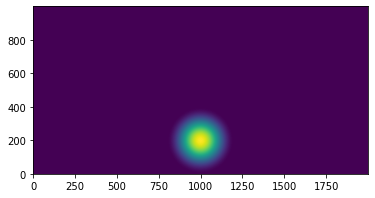

In [3]:
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline
f = netCDF4.Dataset('output.nc', 'r')
theta = f.variables['theta']
plt.imshow(theta[0,:,:], origin='lower')

# 5.0 Summary

In this lab, you have learned:

1. How to build container images using Singularity.  Singularity container images are single "flat" files, making them easy to use at runtime.

2. How to build container images using Docker.  Image layers are an important concept, enabling cached and multi-stage builds.  However, incorrect use of image layers can lead to unnecessarily large container images.

3. HPC Container Maker is an open source tool that simplifies the specification of container images.  From a Python recipe, it can generate either a Dockerfile or a Singularity definition file.  Python is a more powerful language for expression container specifications, and the HPCCM building blocks separate the high level choice of what HPC software components to include in a container image from the low level complexities.

You should now understand the benefits of building HPC container images using the workflow:

1. Specify the content of container images with [HPC Container Maker](https://github.com/NVIDIA/hpc-container-maker)
2. Build container images with Docker
3. Convert the Docker images to Singularity images
4. Use Singularity to run containers on your HPC system

## Appendix: Converting Docker Container Images with Singularity 2.x

The `docker-daemon` endpoint was introduced in Singularity 3.0.  Fortunately there is a convenient [container to convert local Docker images into Singularity 2.x images](https://hub.docker.com/r/singularityware/docker2singularity) available on Docker Hub.

For example, to convert the MPI Bandwidth container image to a Singularty 2.x `simg`:

In [ ]:
!sudo docker run -t --rm --cap-add SYS_ADMIN -v /var/run/docker.sock:/var/run/docker.sock -v /tmp:/output singularityware/docker2singularity mpi_bandwidth

## Appendix: Terminology

- Container: a running instantiation of a container image

- Container image: a standalone "package" of software that includes everything needed to run an application

- Container runtime: a software framework to run and manage containers and container images.  Examples: Docker, Singularity.

- Container registry: a server hosting container images for download ("pulling").  Examples: Docker Hub, Singularity Hub, NVIDIA GPU Cloud (NGC).

## Appendix: Getting Your System Container Ready

Docker and Singularity have been setup already for you in this lab environment. For more information on installing Singularity on your system, please see this brief [video](https://www.youtube.com/watch?v=iOLVqqHQsBU).